In [3]:
import numpy as np
np.random.seed(1)
import torch
import torch.optim as optim
torch.manual_seed(1)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(1)
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from timeit import default_timer as timer

# Dataset preparation and helper functions

In [4]:
# Let's define some hyper-parameters
hparams = {
    'batch_size':8,
    'num_epochs':10,
    'test_batch_size':64,
    'hidden_size':128,
    'num_classes':10,
    'num_inputs':784,
    'learning_rate':1e-3,
    'log_interval':100,
}

# we select to work on GPU if it is available in the machine, otherwise
# will run on CPU
hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=hparams['batch_size'],
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
eval_loader = torch.utils.data.DataLoader(testset, batch_size=hparams['batch_size'],
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


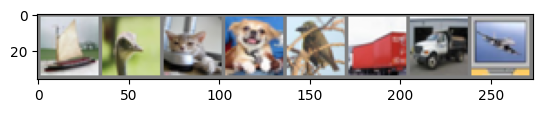

ship  bird  cat   dog   bird  truck truck plane


In [6]:
from torchvision.utils import make_grid
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(hparams['batch_size'])))

In [7]:
def correct_predictions(predicted_batch, label_batch):
  pred = predicted_batch.argmax(dim=1, keepdim=True) # get the index of the max log-probability
  acum = pred.eq(label_batch.view_as(pred)).sum().item()
  return acum

def train_epoch(train_loader, network, optimizer, criterion, hparams, epoch):
  # Activate the train=True flag inside the model
  network.train()
  device = hparams['device']
  losses = []
  accs = []
  for batch_idx, (data, target) in enumerate(train_loader, 1):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = network(data)
      loss = criterion(output, target)
      loss.backward()
      acc = 100 * (correct_predictions(output, target) / data.shape[0])
      losses.append(loss.item())
      accs.append(acc)
      optimizer.step()
      if batch_idx % hparams['log_interval'] == 0 or batch_idx >= len(train_loader):
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAcc: {:.1f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item(),
              acc))
  print('Mean training accuracy: {:.1f}'.format(np.mean(accs)))
  return np.mean(losses), np.mean(accs)

def eval_epoch(eval_loader, network, criterion, hparams):
    network.eval()
    device = hparams['device']
    eval_loss = 0
    acc = 0
    with torch.no_grad():
        for data, target in eval_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            eval_loss += criterion(output, target, reduction='sum').item() # sum up batch loss
            # compute number of correct predictions in the batch
            acc += correct_predictions(output, target)
    # Average acc across all correct predictions batches now
    eval_loss /= len(eval_loader.dataset)
    eval_acc = 100. * acc / len(eval_loader.dataset)
    print('Eval set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        eval_loss, acc, len(eval_loader.dataset), eval_acc,
        ))
    return eval_loss, eval_acc

def train_net(network, train_loader, optimizer, num_epochs, criterion=F.nll_loss, plot=True):
  """ Function that trains and evals a network for num_epochs,
      showing the plot of losses and accs and returning them.
  """
  tr_losses = []
  tr_accs = []
  te_losses = []
  te_accs = []

  network.to(hparams['device'])
  
  for epoch in range(1, num_epochs + 1):
    tr_loss, tr_acc = train_epoch(train_loader, network, optimizer, criterion, hparams, epoch)
    te_loss, te_acc = eval_epoch(eval_loader, network, criterion, hparams)
    te_losses.append(te_loss)
    te_accs.append(te_acc)
    tr_losses.append(tr_loss)
    tr_accs.append(tr_acc)
  rets = {'tr_losses':tr_losses, 'te_losses':te_losses,
          'tr_accs':tr_accs, 'te_accs':te_accs}
  if plot:
    plt.figure(figsize=(10, 8))
    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('NLLLoss')
    plt.plot(tr_losses, label='train')
    plt.plot(te_losses, label='eval')
    plt.legend()
    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Eval Accuracy [%]')
    plt.plot(tr_accs, label='train')
    plt.plot(te_accs, label='eval')
    plt.legend()
  return rets

# Define model

In [8]:
class Net(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        #self.batch_norm1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        #self.batch_norm2 = nn.BatchNorm2d(64)

        self.fc1 = nn.Linear(8*8*64, 128)
        self.fc2 = nn.Linear(128, 10)

        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x=x.view(-1, 8*8*64)
        x = F.relu(self.fc1(x))
        y = F.relu(self.fc2(x))
        return y

# Let's forward a toy example emulating the CIFAR10 image size
plenet = Net()
y = plenet(torch.randn(1, 3, 32, 32))
print(y.shape)

torch.Size([1, 10])


In [9]:
class BigNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        #self.batch_norm1 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        #self.batch_norm2 = nn.BatchNorm2d(64)

        self.fc1 = nn.Linear(8*8*64, 128)
        self.fc2 = nn.Linear(128, 10)

        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x=x.view(-1, 8*8*64)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.log_softmax(x,dim=1)

# Let's forward a toy example emulating the CIFAR10 image size
plenet = Net()
y = plenet(torch.randn(1, 3, 32, 32))
print(y.shape)

torch.Size([1, 10])


Train Epoch: 1 [800/50000 (2%)]	Loss: 2.317397	Acc: 0.0
Train Epoch: 1 [1600/50000 (3%)]	Loss: 2.286245	Acc: 12.5
Train Epoch: 1 [2400/50000 (5%)]	Loss: 2.227015	Acc: 37.5
Train Epoch: 1 [3200/50000 (6%)]	Loss: 2.304051	Acc: 25.0
Train Epoch: 1 [4000/50000 (8%)]	Loss: 2.220814	Acc: 12.5
Train Epoch: 1 [4800/50000 (10%)]	Loss: 2.324075	Acc: 12.5
Train Epoch: 1 [5600/50000 (11%)]	Loss: 2.111996	Acc: 37.5
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.601531	Acc: 0.0
Train Epoch: 1 [7200/50000 (14%)]	Loss: 2.177416	Acc: 12.5
Train Epoch: 1 [8000/50000 (16%)]	Loss: 2.137838	Acc: 25.0
Train Epoch: 1 [8800/50000 (18%)]	Loss: 2.709413	Acc: 0.0
Train Epoch: 1 [9600/50000 (19%)]	Loss: 2.298862	Acc: 0.0
Train Epoch: 1 [10400/50000 (21%)]	Loss: 1.649095	Acc: 50.0
Train Epoch: 1 [11200/50000 (22%)]	Loss: 1.904035	Acc: 25.0
Train Epoch: 1 [12000/50000 (24%)]	Loss: 1.785293	Acc: 50.0
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.154350	Acc: 25.0
Train Epoch: 1 [13600/50000 (27%)]	Loss: 2.049317	Acc: 12.5
Tr

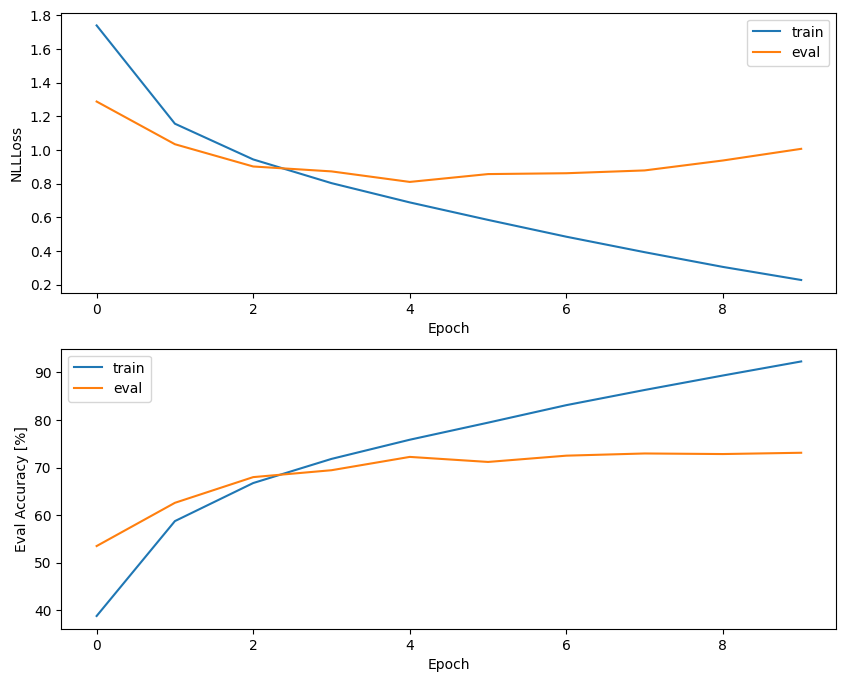

In [10]:
net = Net()
# optimizer = optim.Adam(net.parameters(), lr=hparams['learning_rate'])#, weight_decay=0.001)
# criterion = F.nll_loss
criterion = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=hparams['learning_rate'], momentum=0.9)
model_dout_log = train_net(net, train_loader, optimizer, hparams['num_epochs'], criterion=criterion)

Train Epoch: 1 [800/50000 (2%)]	Loss: 2.294281	Acc: 0.0
Train Epoch: 1 [1600/50000 (3%)]	Loss: 2.284766	Acc: 12.5
Train Epoch: 1 [2400/50000 (5%)]	Loss: 2.296296	Acc: 25.0
Train Epoch: 1 [3200/50000 (6%)]	Loss: 2.286276	Acc: 25.0
Train Epoch: 1 [4000/50000 (8%)]	Loss: 2.292680	Acc: 0.0
Train Epoch: 1 [4800/50000 (10%)]	Loss: 2.300226	Acc: 0.0
Train Epoch: 1 [5600/50000 (11%)]	Loss: 2.298135	Acc: 25.0
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.261588	Acc: 25.0
Train Epoch: 1 [7200/50000 (14%)]	Loss: 2.301693	Acc: 12.5
Train Epoch: 1 [8000/50000 (16%)]	Loss: 2.302752	Acc: 12.5
Train Epoch: 1 [8800/50000 (18%)]	Loss: 2.291206	Acc: 12.5
Train Epoch: 1 [9600/50000 (19%)]	Loss: 2.202337	Acc: 12.5
Train Epoch: 1 [10400/50000 (21%)]	Loss: 1.821300	Acc: 37.5
Train Epoch: 1 [11200/50000 (22%)]	Loss: 2.206468	Acc: 0.0
Train Epoch: 1 [12000/50000 (24%)]	Loss: 1.969892	Acc: 37.5
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.826727	Acc: 37.5
Train Epoch: 1 [13600/50000 (27%)]	Loss: 1.833612	Acc: 37.5
Tr

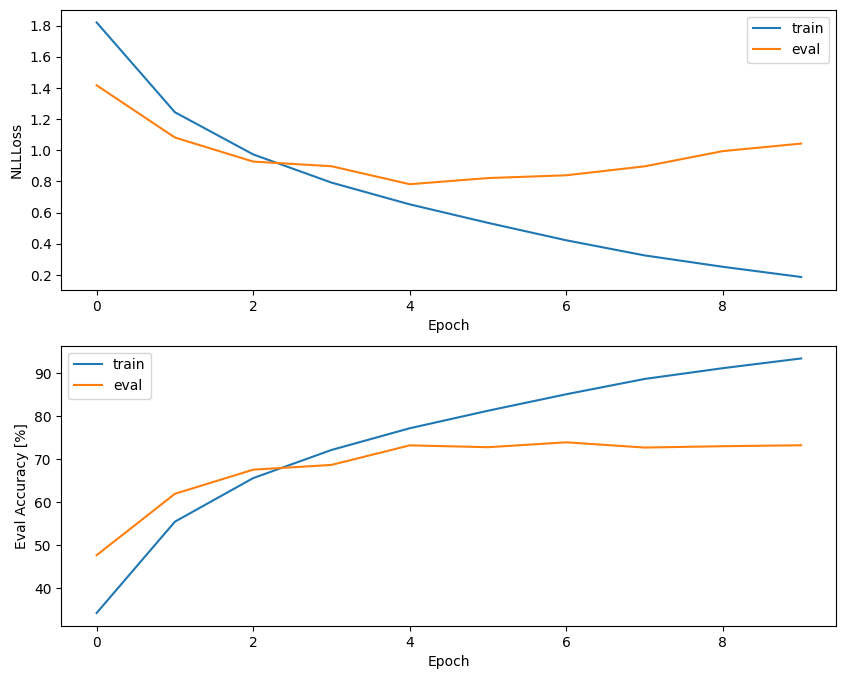

In [11]:
net = BigNet()
# optimizer = optim.Adam(net.parameters(), lr=hparams['learning_rate'])#, weight_decay=0.001)
# criterion = F.nll_loss
criterion = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=hparams['learning_rate'], momentum=0.9)
model_dout_log = train_net(net, train_loader, optimizer, hparams['num_epochs'], criterion=criterion)

### Memory requirements and Computational load

In [12]:
NUM_BITS_FLOAT32 = 32

# Let's define a class that encapsulates a collection of layers we pass in
# for each forwarded layer, it retains the amount of consumed memory for
# the returned feature map. It also displays the total amount used after
# all blocks are ran.

class CNNMemAnalyzer(nn.Module):

  def __init__(self, layers):
    super().__init__()
    self.layers = layers

  def forward(self, x):
    tot_mbytes = 0
    spat_res = []
    for layer in self.layers:
      h = layer(x)
      mem_h_bytes = np.cumprod(h.shape)[-1] * NUM_BITS_FLOAT32 // 8
      mem_h_mb = mem_h_bytes / 1e6
      print('-' * 30)
      print('New feature map of shape: ', h.shape)
      print('Mem usage: {} MB'.format(mem_h_mb))
      x = h
      if isinstance(layer, nn.Conv2d):
        # keep track of the current spatial width for conv layers
        spat_res.append(h.shape[-1])
      tot_mbytes += mem_h_mb
    print('=' * 30)
    print('Total used memory: {:.2f} MB'.format(tot_mbytes))
    return tot_mbytes, spat_res

In [13]:
# Now, let's make a stack of convlayers combined with MaxPoolings
cnn = CNNMemAnalyzer(nn.ModuleList([nn.Conv2d(3, 32, 3, padding=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2),
                                    nn.Conv2d(32, 64, 3, padding=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2),
                                    nn.Flatten(),
                                    nn.Linear(8*8*64, 128),
                                    nn.ReLU(),
                                    nn.Linear(128,10)
                                    ]))

beg_t = timer()
pool_mbytes, pool_res = cnn(torch.randn(1, 3, 32, 32))
end_t = timer()
pool_time = end_t - beg_t
print('Total inference time for pooled CNN: {:.2f} s'.format(pool_time))

------------------------------
New feature map of shape:  torch.Size([1, 32, 32, 32])
Mem usage: 0.131072 MB
------------------------------
New feature map of shape:  torch.Size([1, 32, 32, 32])
Mem usage: 0.131072 MB
------------------------------
New feature map of shape:  torch.Size([1, 32, 16, 16])
Mem usage: 0.032768 MB
------------------------------
New feature map of shape:  torch.Size([1, 64, 16, 16])
Mem usage: 0.065536 MB
------------------------------
New feature map of shape:  torch.Size([1, 64, 16, 16])
Mem usage: 0.065536 MB
------------------------------
New feature map of shape:  torch.Size([1, 64, 8, 8])
Mem usage: 0.016384 MB
------------------------------
New feature map of shape:  torch.Size([1, 4096])
Mem usage: 0.016384 MB
------------------------------
New feature map of shape:  torch.Size([1, 128])
Mem usage: 0.000512 MB
------------------------------
New feature map of shape:  torch.Size([1, 128])
Mem usage: 0.000512 MB
------------------------------
New featur

### Computational load

In [14]:
# Not sure how to do this other than the recorded duration time  in the above cell. 

# Task 2: Experiments

### Data augmentation

In [15]:
augmentation_transform = transforms.Compose([transforms.RandomHorizontalFlip(), 
                                           transforms.RandomRotation(10), 
                                           #transforms.RandomResizedCrop(150), Not needed since all images are same size
                                           transforms.RandomHorizontalFlip(),
                                           transforms.ToTensor(),
                                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

augmented_trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=augmentation_transform)
augmented_train_loader = torch.utils.data.DataLoader(augmented_trainset, batch_size=hparams['batch_size'],
                                          shuffle=True, num_workers=2)

# Test set is not augmented


Files already downloaded and verified


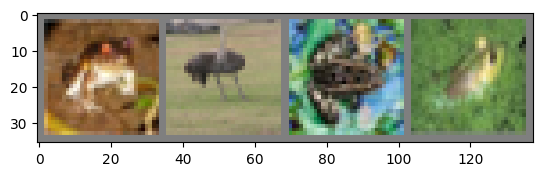

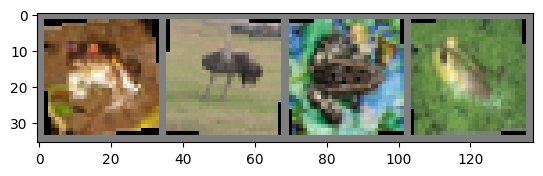

ship  bird  cat   dog   bird  truck truck plane


In [16]:
from torchvision.utils import make_grid
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

random_indices = [0, 42, 200, 242]
augmented_images = [augmented_trainset[i][0] for i in random_indices]

images = [trainset[i][0] for i in random_indices]

# show images
imshow(make_grid(images))
imshow(make_grid(augmented_images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(hparams['batch_size'])))

Train Epoch: 1 [800/50000 (2%)]	Loss: 2.280346	Acc: 25.0
Train Epoch: 1 [1600/50000 (3%)]	Loss: 2.195241	Acc: 37.5
Train Epoch: 1 [2400/50000 (5%)]	Loss: 2.384391	Acc: 12.5
Train Epoch: 1 [3200/50000 (6%)]	Loss: 2.367047	Acc: 12.5
Train Epoch: 1 [4000/50000 (8%)]	Loss: 1.920295	Acc: 37.5
Train Epoch: 1 [4800/50000 (10%)]	Loss: 2.243079	Acc: 25.0
Train Epoch: 1 [5600/50000 (11%)]	Loss: 2.379046	Acc: 12.5
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.289431	Acc: 12.5
Train Epoch: 1 [7200/50000 (14%)]	Loss: 1.973323	Acc: 37.5
Train Epoch: 1 [8000/50000 (16%)]	Loss: 2.258157	Acc: 25.0
Train Epoch: 1 [8800/50000 (18%)]	Loss: 2.161772	Acc: 25.0
Train Epoch: 1 [9600/50000 (19%)]	Loss: 2.447883	Acc: 12.5
Train Epoch: 1 [10400/50000 (21%)]	Loss: 1.957791	Acc: 12.5
Train Epoch: 1 [11200/50000 (22%)]	Loss: 1.641722	Acc: 37.5
Train Epoch: 1 [12000/50000 (24%)]	Loss: 1.347451	Acc: 50.0
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.598526	Acc: 37.5
Train Epoch: 1 [13600/50000 (27%)]	Loss: 2.315816	Acc: 12.

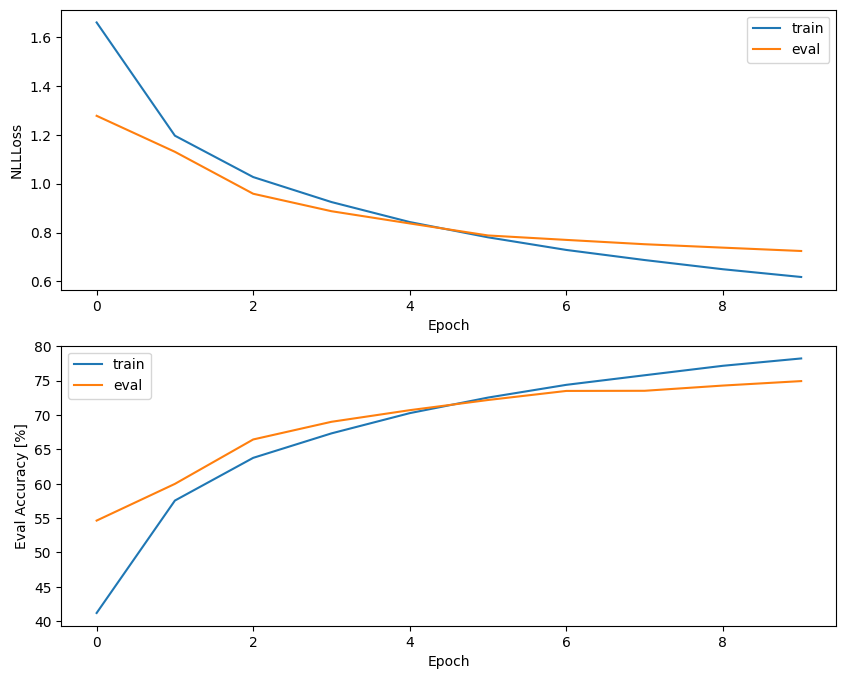

In [17]:
net = Net()

loader = augmented_train_loader

criterion = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=hparams['learning_rate'], momentum=0.9)
model_dout_log = train_net(net, loader, optimizer, hparams['num_epochs'], criterion=criterion)

### Varying batch size

#############################################################################
Batch size:  1
Train Epoch: 1 [100/50000 (0%)]	Loss: 2.240361	Acc: 100.0
Train Epoch: 1 [200/50000 (0%)]	Loss: 2.155756	Acc: 0.0
Train Epoch: 1 [300/50000 (1%)]	Loss: 2.406345	Acc: 0.0
Train Epoch: 1 [400/50000 (1%)]	Loss: 2.386603	Acc: 0.0
Train Epoch: 1 [500/50000 (1%)]	Loss: 1.890217	Acc: 100.0
Train Epoch: 1 [600/50000 (1%)]	Loss: 2.469990	Acc: 0.0
Train Epoch: 1 [700/50000 (1%)]	Loss: 2.578606	Acc: 0.0
Train Epoch: 1 [800/50000 (2%)]	Loss: 2.528361	Acc: 0.0
Train Epoch: 1 [900/50000 (2%)]	Loss: 2.332705	Acc: 0.0
Train Epoch: 1 [1000/50000 (2%)]	Loss: 2.410484	Acc: 0.0
Train Epoch: 1 [1100/50000 (2%)]	Loss: 2.436794	Acc: 0.0
Train Epoch: 1 [1200/50000 (2%)]	Loss: 2.089165	Acc: 100.0
Train Epoch: 1 [1300/50000 (3%)]	Loss: 1.264729	Acc: 100.0
Train Epoch: 1 [1400/50000 (3%)]	Loss: 2.489164	Acc: 0.0
Train Epoch: 1 [1500/50000 (3%)]	Loss: 2.093275	Acc: 0.0
Train Epoch: 1 [1600/50000 (3%)]	Loss: 2.149468	Acc: 

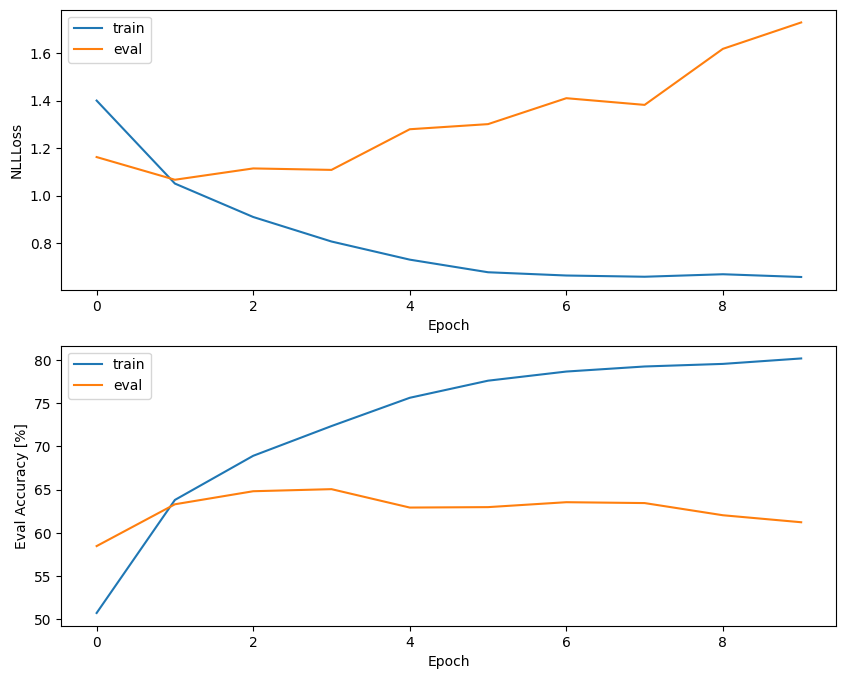

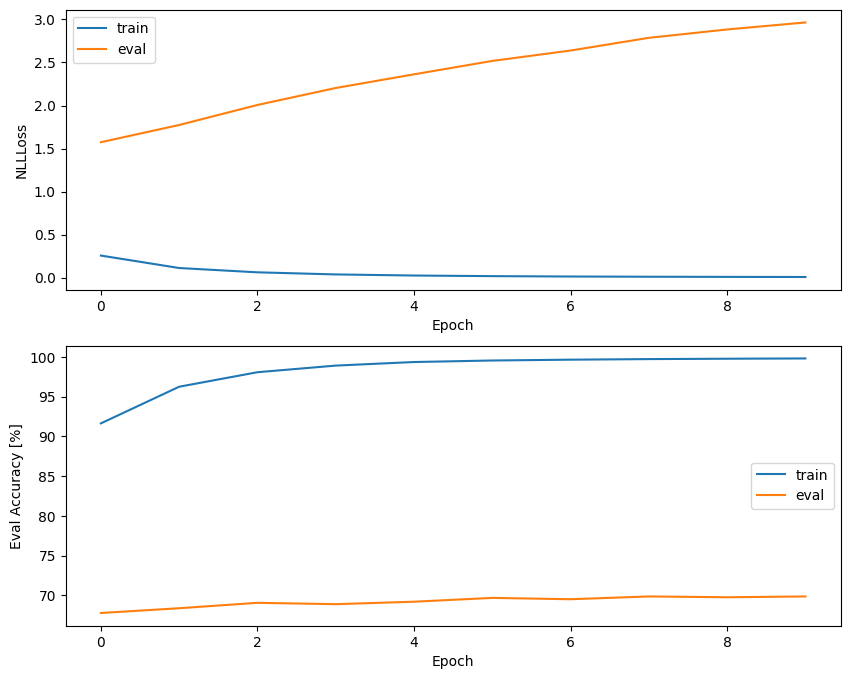

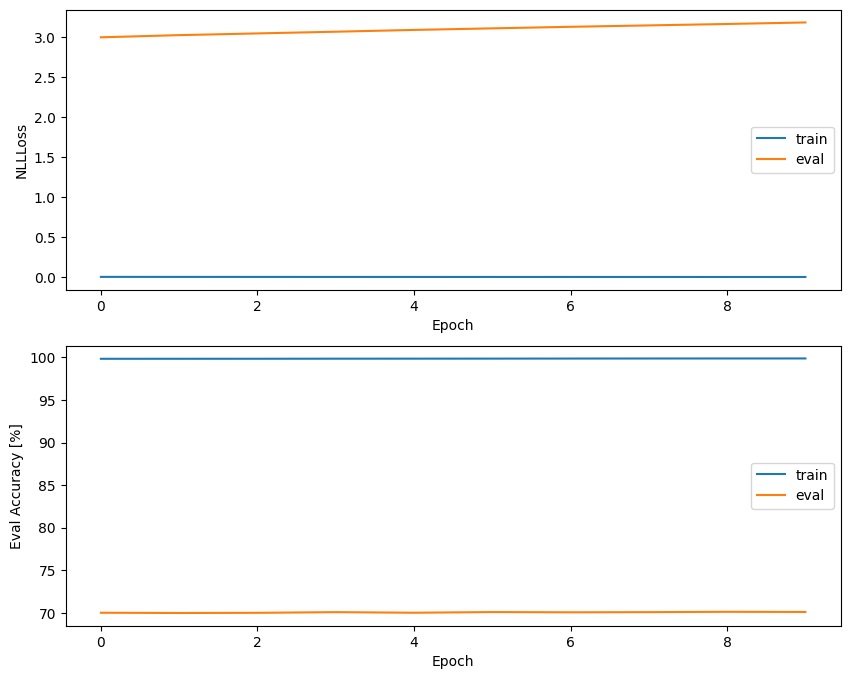

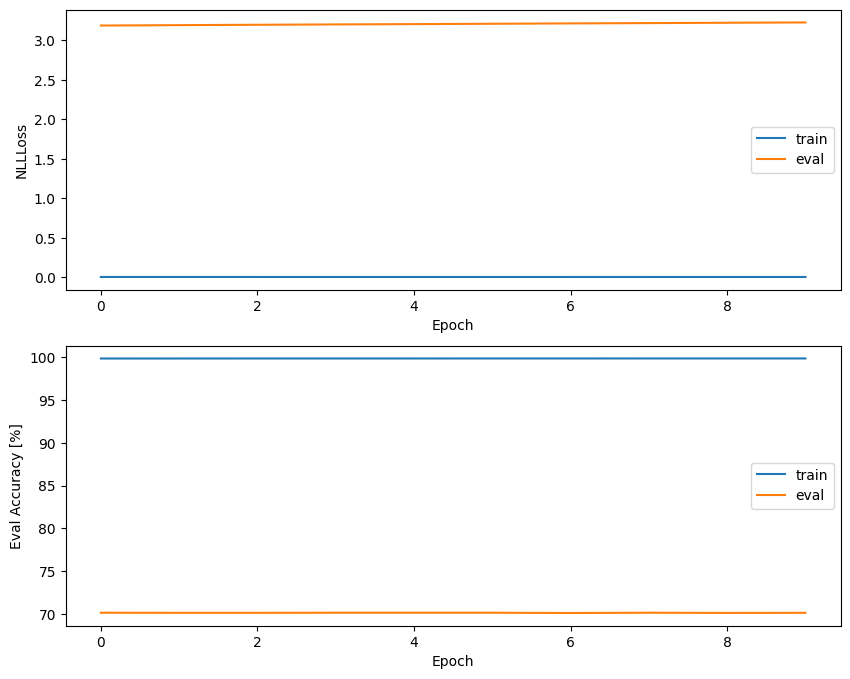

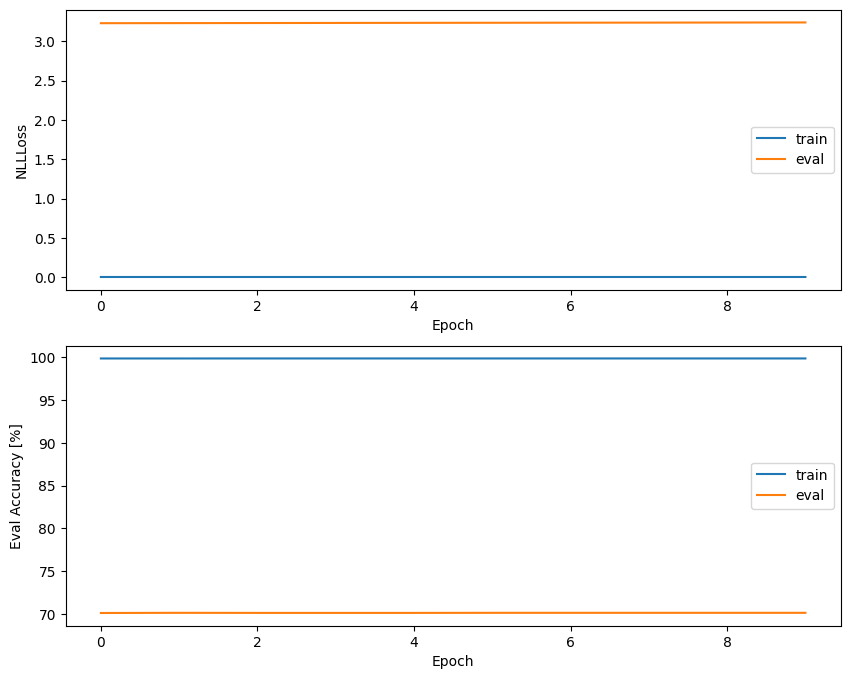

In [33]:
import time

batch_sizes = [1,4,16,64,256]
hparams['num_epochs'] = 10

net = Net()
# optimizer = optim.Adam(net.parameters(), lr=hparams['learning_rate'])#, weight_decay=0.001)
# criterion = F.nll_loss
criterion = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=hparams['learning_rate'], momentum=0.9)

model_logs = []
time_durations = []

for batch_size in batch_sizes:
    hparams['batch_size'] = batch_size

    print('#############################################################################')
    print('Batch size: ', batch_size)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=hparams['batch_size'],
                                            shuffle=True, num_workers=2)

    eval_loader = torch.utils.data.DataLoader(testset, batch_size=hparams['batch_size'],
                                            shuffle=False, num_workers=2)
    
    start = time.time()
    model_dout_log = train_net(net, train_loader, optimizer, hparams['num_epochs'], criterion=criterion)
    end = time.time()
    time_durations.append(end-start)
    model_logs.append(model_dout_log)

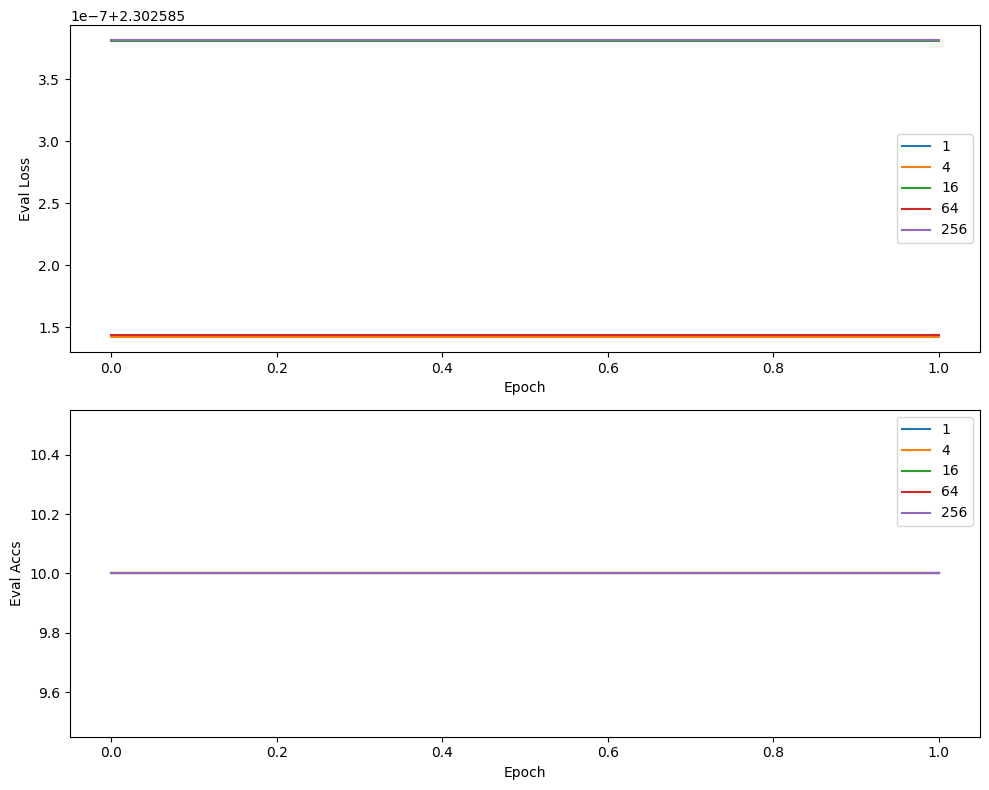

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

for i, log in enumerate(model_logs):
    plt.subplot(2,1,1)
    plt.plot(log['te_losses'], label=str(batch_sizes[i]))
    plt.subplot(2,1,2)
    plt.plot(log['te_accs'], label=str(batch_sizes[i]))

plt.subplot(2,1,1)
plt.xlabel('Epoch')
plt.ylabel('Eval Loss')
plt.legend()

plt.subplot(2,1,2)
plt.xlabel('Epoch')
plt.ylabel('Eval Accs')
plt.legend()

plt.tight_layout()

Text(0, 0.5, 'Training time')

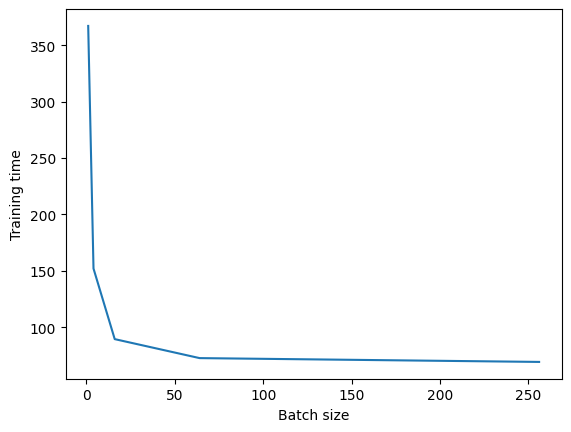

In [20]:
plt.plot(batch_sizes, time_durations)
plt.xlabel('Batch size')
plt.ylabel('Training time')

In [ ]:
plt.plot(model_logs)

### Batch normalization

In [21]:
class BatchNormalizationNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(64)

        self.fc1 = nn.Linear(8*8*64, 128)
        self.fc2 = nn.Linear(128, 10)

        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.batch_norm1(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.batch_norm2(x)
        x = x.view(-1, 8*8*64)
        x = F.relu(self.fc1(x))
        y = F.relu(self.fc2(x))
        return y

Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.746907	Acc: 39.1
Train Epoch: 1 [15680/50000 (100%)]	Loss: 1.519014	Acc: 51.2
Mean training accuracy: 36.0
Eval set: Average loss: 1.5396, Accuracy: 4643/10000 (46%)
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.329990	Acc: 57.0
Train Epoch: 2 [15680/50000 (100%)]	Loss: 1.347012	Acc: 53.8
Mean training accuracy: 50.7
Eval set: Average loss: 1.3081, Accuracy: 5401/10000 (54%)


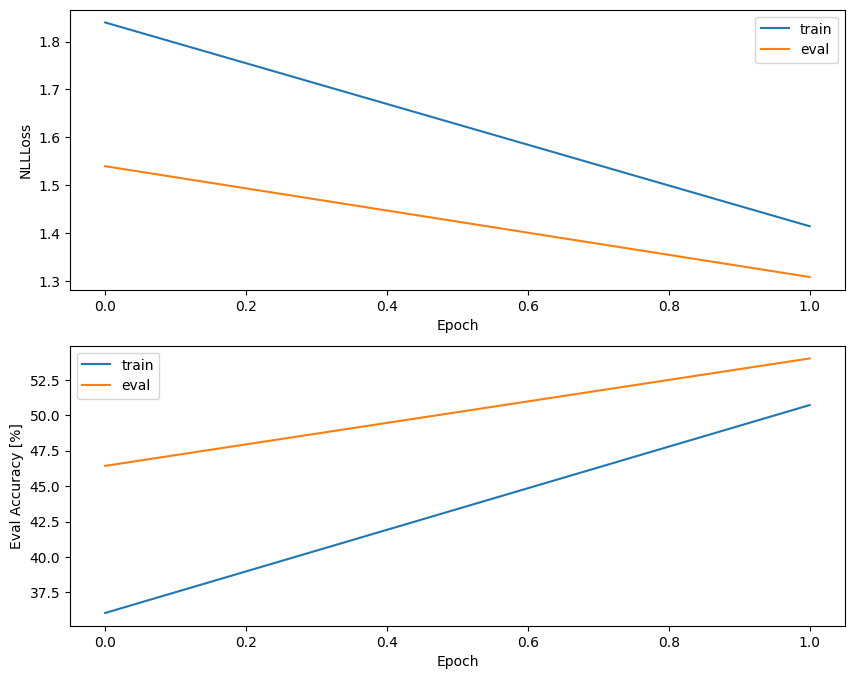

In [22]:
net = BatchNormalizationNet()
# optimizer = optim.Adam(net.parameters(), lr=hparams['learning_rate'])#, weight_decay=0.001)
# criterion = F.nll_loss
criterion = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=hparams['learning_rate'], momentum=0.9)
model_dout_log = train_net(net, train_loader, optimizer, hparams['num_epochs'], criterion=criterion)

## Force overfit 

In [23]:
# Add possibility to add L2 weight regularization, Dropout, 

class OverfitNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        #self.batch_norm1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        #self.batch_norm2 = nn.BatchNorm2d(64)

        self.fc1 = nn.Linear(8*8*64, 128)
        self.fc2 = nn.Linear(128, 10)

        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x=x.view(-1, 8*8*64)
        x = F.relu(self.fc1(x))
        y = F.relu(self.fc2(x))
        return y

In [24]:
class DropoutNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        #self.batch_norm1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        #self.batch_norm2 = nn.BatchNorm2d(64)

        self.fc1 = nn.Linear(8*8*64, 128)
        self.fc2 = nn.Linear(128, 10)

        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x=x.view(-1, 8*8*64)
        x = F.relu(self.fc1(x))
        y = F.relu(self.fc2(x))
        return y

In [25]:
model_logs = {}

Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.291746	Acc: 17.6
Train Epoch: 1 [15680/50000 (100%)]	Loss: 2.277369	Acc: 18.8
Mean training accuracy: 15.4
Eval set: Average loss: 2.2779, Accuracy: 1920/10000 (19%)
Train Epoch: 2 [25600/50000 (51%)]	Loss: 2.254797	Acc: 21.9
Train Epoch: 2 [15680/50000 (100%)]	Loss: 2.227443	Acc: 20.0
Mean training accuracy: 21.8
Eval set: Average loss: 2.2097, Accuracy: 2491/10000 (25%)


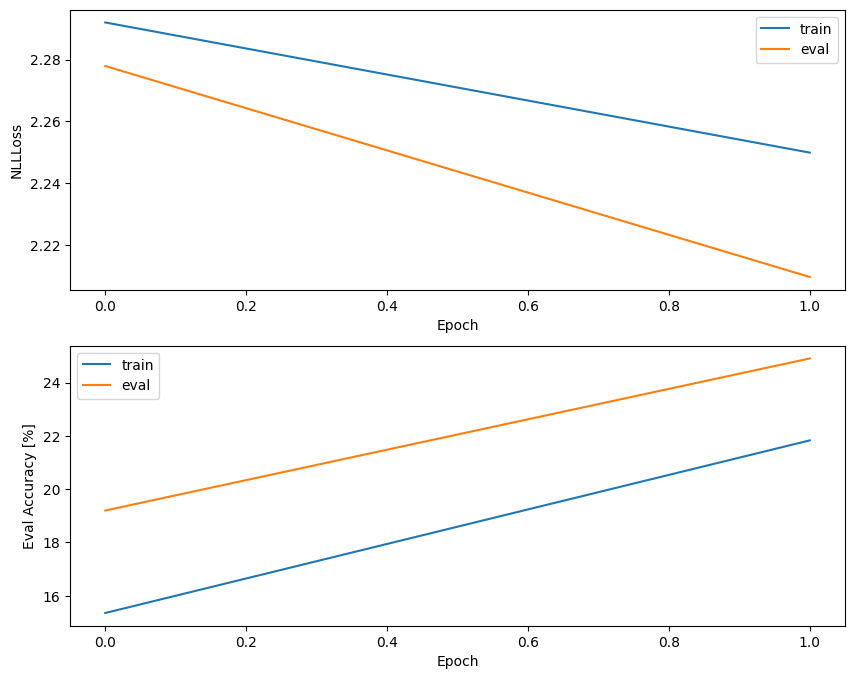

In [26]:
# Overfitted net

net = OverfitNet()
# optimizer = optim.Adam(net.parameters(), lr=hparams['learning_rate'])#, weight_decay=0.001)
# criterion = F.nll_loss
criterion = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=hparams['learning_rate'], momentum=0.9)
model_dout_log = train_net(net, train_loader, optimizer, hparams['num_epochs'], criterion=criterion)

model_logs['Overfitted'] = model_dout_log

Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.294924	Acc: 14.8
Train Epoch: 1 [15680/50000 (100%)]	Loss: 2.295068	Acc: 18.8
Mean training accuracy: 15.7
Eval set: Average loss: 2.2924, Accuracy: 1916/10000 (19%)
Train Epoch: 2 [25600/50000 (51%)]	Loss: 2.294889	Acc: 16.0
Train Epoch: 2 [15680/50000 (100%)]	Loss: 2.293465	Acc: 18.8
Mean training accuracy: 19.2
Eval set: Average loss: 2.2810, Accuracy: 1991/10000 (20%)


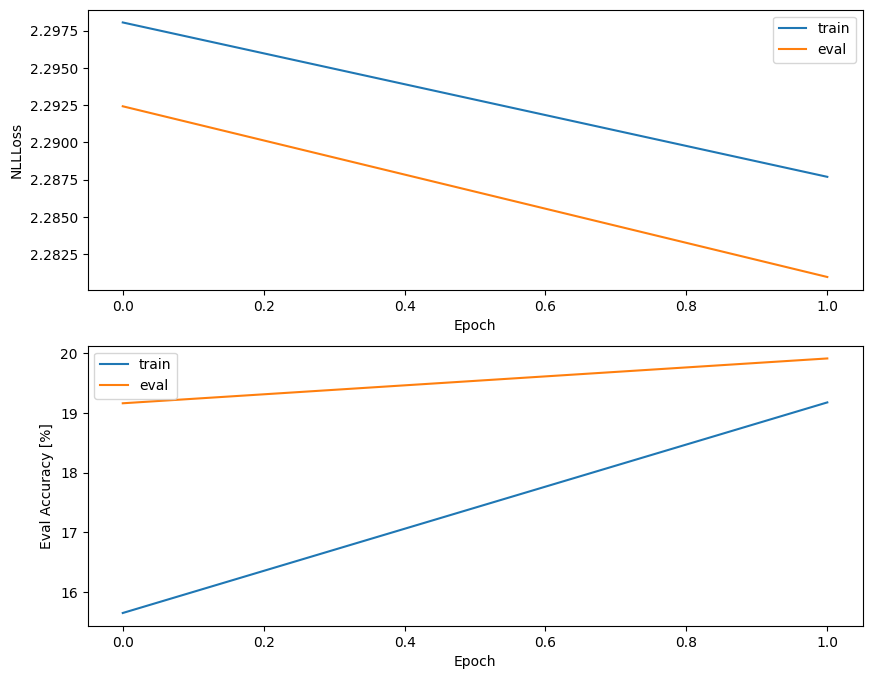

In [27]:
# Adding L2 regularization

weight_decay = 0.001

net = OverfitNet()
# optimizer = optim.Adam(net.parameters(), lr=hparams['learning_rate'])#, weight_decay=0.001)
# criterion = F.nll_loss
criterion = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=hparams['learning_rate'], momentum=0.9, weight_decay=weight_decay)
model_dout_log = train_net(net, train_loader, optimizer, hparams['num_epochs'], criterion=criterion)

model_logs['L2-reg'] = model_dout_log

Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.293269	Acc: 17.2
Train Epoch: 1 [15680/50000 (100%)]	Loss: 2.253161	Acc: 25.0
Mean training accuracy: 18.7
Eval set: Average loss: 2.2687, Accuracy: 2247/10000 (22%)
Train Epoch: 2 [25600/50000 (51%)]	Loss: 2.249300	Acc: 24.6
Train Epoch: 2 [15680/50000 (100%)]	Loss: 2.219316	Acc: 21.2
Mean training accuracy: 24.1
Eval set: Average loss: 2.1886, Accuracy: 2613/10000 (26%)


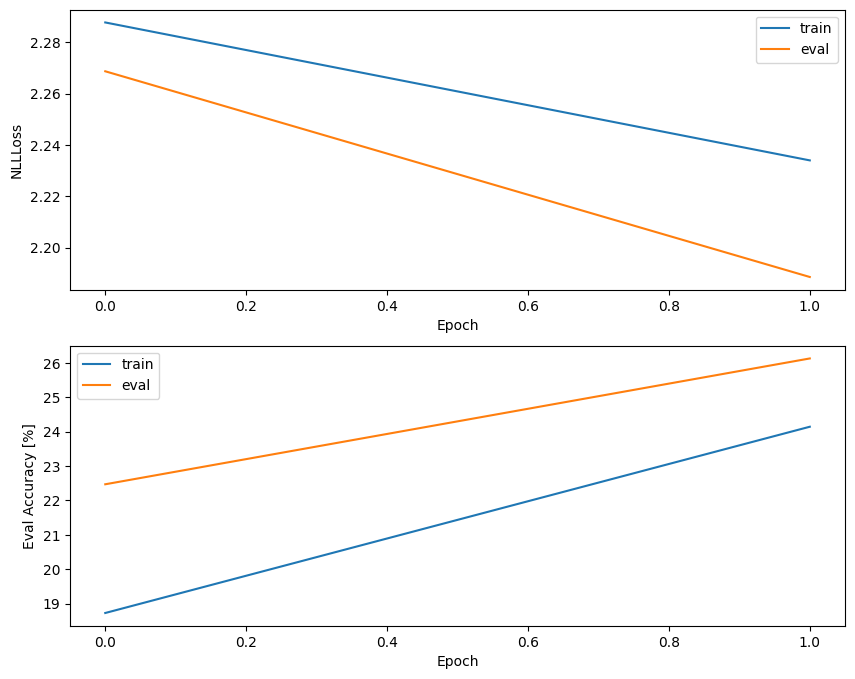

In [28]:
# Adding dropout

net = DropoutNet()
# optimizer = optim.Adam(net.parameters(), lr=hparams['learning_rate'])#, weight_decay=0.001)
# criterion = F.nll_loss
criterion = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=hparams['learning_rate'], momentum=0.9)
model_dout_log = train_net(net, train_loader, optimizer, hparams['num_epochs'], criterion=criterion)

model_logs['Dropout'] = model_dout_log

Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.295254	Acc: 17.6
Train Epoch: 1 [15680/50000 (100%)]	Loss: 2.284877	Acc: 16.2
Mean training accuracy: 15.9
Eval set: Average loss: 2.2838, Accuracy: 1856/10000 (19%)
Train Epoch: 2 [25600/50000 (51%)]	Loss: 2.266146	Acc: 18.8
Train Epoch: 2 [15680/50000 (100%)]	Loss: 2.241524	Acc: 22.5
Mean training accuracy: 20.5
Eval set: Average loss: 2.2307, Accuracy: 2268/10000 (23%)


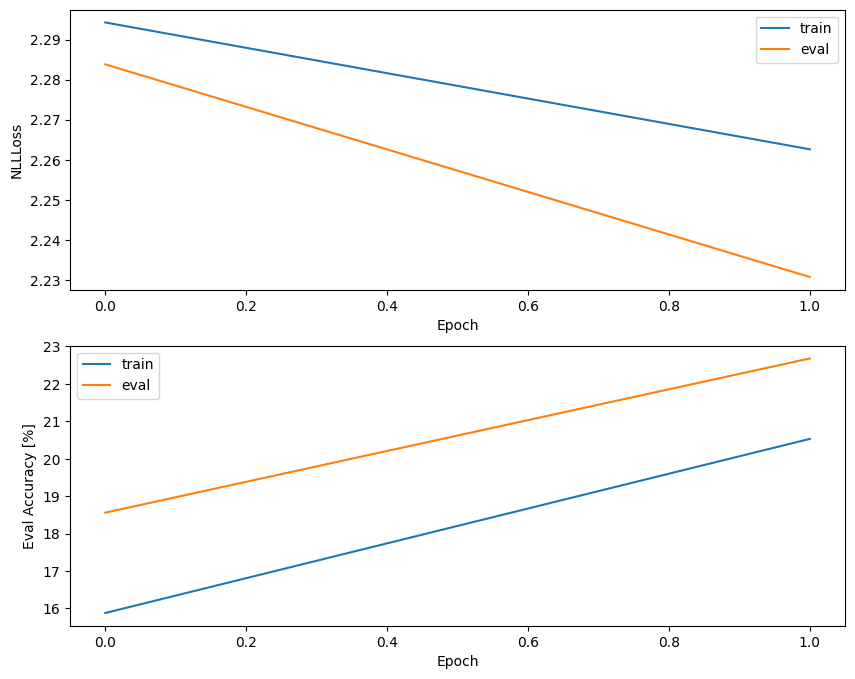

In [29]:
# Adding L2 regularization adn dropout

net = DropoutNet()
# optimizer = optim.Adam(net.parameters(), lr=hparams['learning_rate'])#, weight_decay=0.001)
# criterion = F.nll_loss
criterion = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=hparams['learning_rate'], momentum=0.9, weight_decay=weight_decay)
model_dout_log = train_net(net, train_loader, optimizer, hparams['num_epochs'], criterion=criterion)

model_logs['L2-reg and dropout'] = model_dout_log

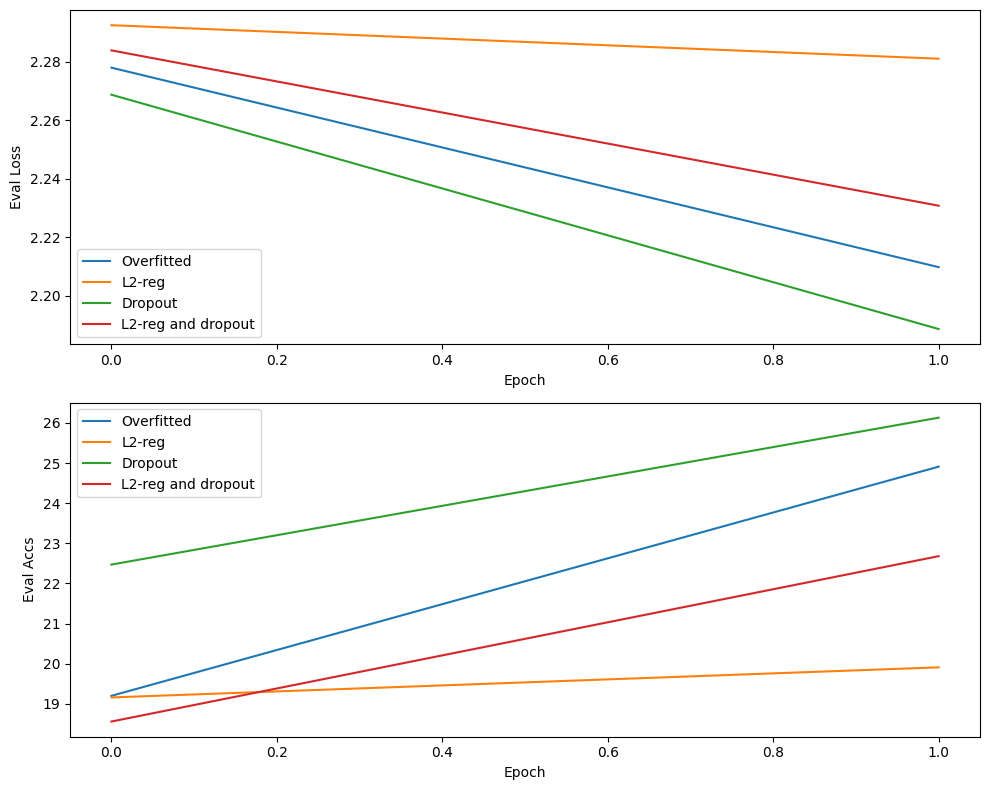

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

for label, log in model_logs.items():
    plt.subplot(2,1,1)
    plt.plot(log['te_losses'], label=label)
    plt.subplot(2,1,2)
    plt.plot(log['te_accs'], label=label)

plt.subplot(2,1,1)
plt.xlabel('Epoch')
plt.ylabel('Eval Loss')
plt.legend()

plt.subplot(2,1,2)
plt.xlabel('Epoch')
plt.ylabel('Eval Accs')
plt.legend()

plt.tight_layout()

# Task 3: Interpretability

In [31]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=hparams['batch_size'],
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
eval_loader = torch.utils.data.DataLoader(testset, batch_size=hparams['batch_size'],
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [32]:
import torchvision.models

custom_model = Net()
vgg16_model = torchvision.models.vgg16()

# -------------------------------------------------------